In [1]:
%matplotlib inline
from __future__ import division
import matplotlib
import numpy as np
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import h5py
import os
import re
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4)})
plotStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
np.seterr(divide='ignore',invalid='ignore')
pass

### Execute with time limit.

In [2]:
%%bash
dirname=data/1
filename=${dirname}/multiple_species_reactions.lm
mkdir -p ${dirname}
rm -f ${filename} && lm_sbml_import ${filename} multiple_species_reactions.sbml
lm_setp ${filename} writeInterval=1e-2 maxTime=1e1
# echo "Execute the following command in `pwd`:"
lmes -r 1-1 -f ${filename} -gr 0

lm_sbml_import v2018.02 build 
Copyright (C) 2012-2018 Roberts Group, Johns Hopkins University.
Copyright (C) 2008-2012 Luthey-Schulten Group, University of Illinois at Urbana-Champaign.


2018-04-11 03:37:26) SBML L3V1 Importer processing document.
2018-04-11 03:37:26) Processing 1 compartments.
2018-04-11 03:37:26) Added compartment (0) V: 1.000000e+00 L
2018-04-11 03:37:26) Processing 2 species.
2018-04-11 03:37:26) Added species (0) n with initial count: 1000
2018-04-11 03:37:26) Added species (1) m with initial count: 100
2018-04-11 03:37:26) Processing 6 reactions.
2018-04-11 03:37:26) Matched kinetic formula in reaction  (0) to FirstOrderPropensity: [0.5 * n] == [k1 * x1]
2018-04-11 03:37:26) Matched kinetic formula in reaction  (1) to ZerothOrderPropensity: [1000] == [k1]
2018-04-11 03:37:26) Matched kinetic formula in reaction  (2) to FirstOrderPropensity: [0.5 * n] == [k1 * x1]
2018-04-11 03:37:26) Matched kinetic formula in reaction  (3) to FirstOrderPropensity: [0.5 * m] ==

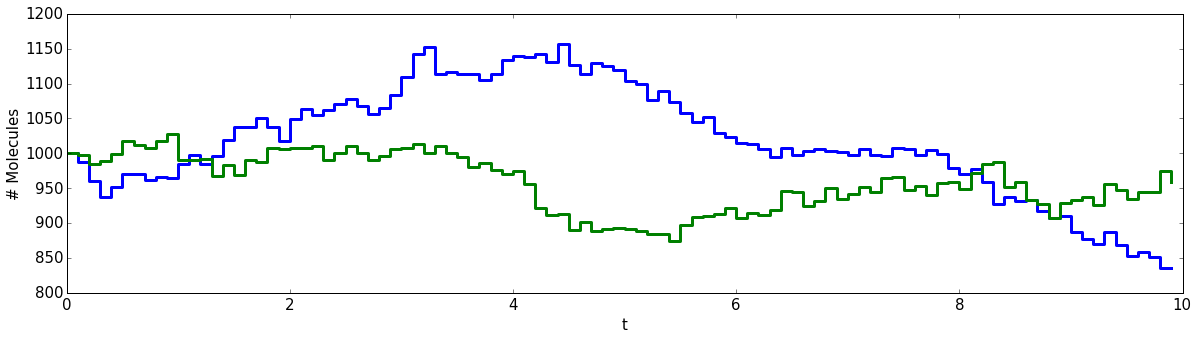

In [108]:
# Plot the time series for a single replicate.
dirname="data/1"
filename="%s/first_order_birth_death.lm"%dirname
fp = h5py.File(filename, "r")
matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (20,5)})
replicate=1
counts=fp["/Simulations/%07d/SpeciesCounts"%replicate]
times=fp["/Simulations/%07d/SpeciesCountTimes"%replicate]
step(times[0:-1:10],counts[0:-1:10], **stepStyles)
replicate=2
counts=fp["/Simulations/%07d/SpeciesCounts"%replicate]
times=fp["/Simulations/%07d/SpeciesCountTimes"%replicate]
step(times[0:-1:10],counts[0:-1:10], **stepStyles)
xlabel('t'); ylabel('# Molecules')

### Performance comparison

Generate the input files and output the commands to run the simulations.

In [1]:
%%bash
dirname=data/perf
filename=${dirname}/first_order_birth_death.lm
mkdir -p ${dirname}
rm -f ${filename} && lm_sbml_import ${filename} first_order_birth_death.sbml
lm_setp ${filename} writeInterval=1e4 maxTime=1e5
echo "Execute the following command in `pwd`:"
echo 'for replicate in `seq -f "%g" 0 10`; do'
echo "echo Running \${replicate};"
echo "lmes -r 1-10 -f ${filename} -c 2 -gr 0 -ff null| tee ${filename}.\`hostname\`.\${replicate}.log";
echo 'done;'


lm_sbml_import v2016.01.20 build 1
Copyright (C) 2008-2012 Luthey-Schulten Group, University of Illinois at Urbana-Champaign.
Copyright (C) 2012-2016 Roberts Group, Johns Hopkins University.


Done.
lm_setp v2016.01.20 build 1
Copyright (C) 2008-2012 Luthey-Schulten Group,
University of Illinois at Urbana-Champaign.

Setting parameters in simulation file data/perf/first_order_birth_death.lm:
maxTime=1e5
writeInterval=1e4
Done.
Execute the following command in /Users/eroberts/Work/Lab/Git/LatticeMicrobesES/regression/first_order_birth_death:
for replicate in `seq -f "%g" 0 10`; do
echo Running ${replicate};
lmes -r 1-10 -f data/perf/first_order_birth_death.lm -c 2 -gr 0 -ff null| tee data/perf/first_order_birth_death.lm.barkeri-clang.${replicate}.log
done;


In [8]:
# Extract the timing data.
datadir="data"
timingData={}
regex0 = re.compile("perf\.(\S+)")
regex1 = re.compile("\.lm\.([^\.]+)\.(\d+)\.log")
regex2 = re.compile("Finished .+ seconds \((\S+) steps/second\)")
for dirname in os.listdir(datadir):
    testType = None
    if dirname == "perf":
        testType = "latest"
    m = regex0.search(dirname)
    if m != None:
        testType = m.group(1)
    if testType is not None:
        for logname in os.listdir(datadir+"/"+dirname):
            m = regex1.search(logname)
            if m != None:
                host=m.group(1)
                replicate=int(m.group(2))
                with open(datadir+"/"+dirname+"/"+logname) as f:
                    for line in f:
                        m = regex2.search(line)
                        if m != None:
                            if host not in timingData:
                                timingData[host]={}
                            if testType not in timingData[host]:
                                timingData[host][testType]=[]
                            timingData[host][testType].append(double(m.group(1)))
                            break

[18165454.545454547, 20157272.727272727, 14144545.454545455, 17122727.272727273]


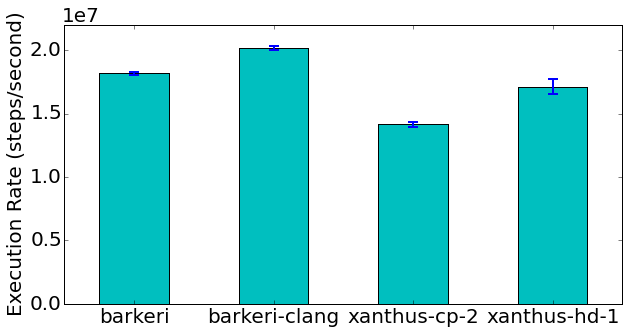

In [9]:
# Plot the latest timing data.
matplotlib.rcParams.update({'font.size': 20, "figure.figsize": (10,5)})
hosts = timingData.keys()
hosts.sort()
times=[]
timesErr=[]
for host in hosts:
    times.append(mean(timingData[host]['latest']))
    timesErr.append(std(timingData[host]['latest']))
plt.bar(arange(0,len(hosts))+0.25,times,width=0.5,yerr=timesErr, color='c', error_kw={"elinewidth":2,"capsize":5,"capthick":2})
plt.ylabel('Execution Rate (steps/second)')
plt.xticks(arange(0,len(hosts))+0.5, hosts)
plt.ylim([0,2.2e7])
print times
pass

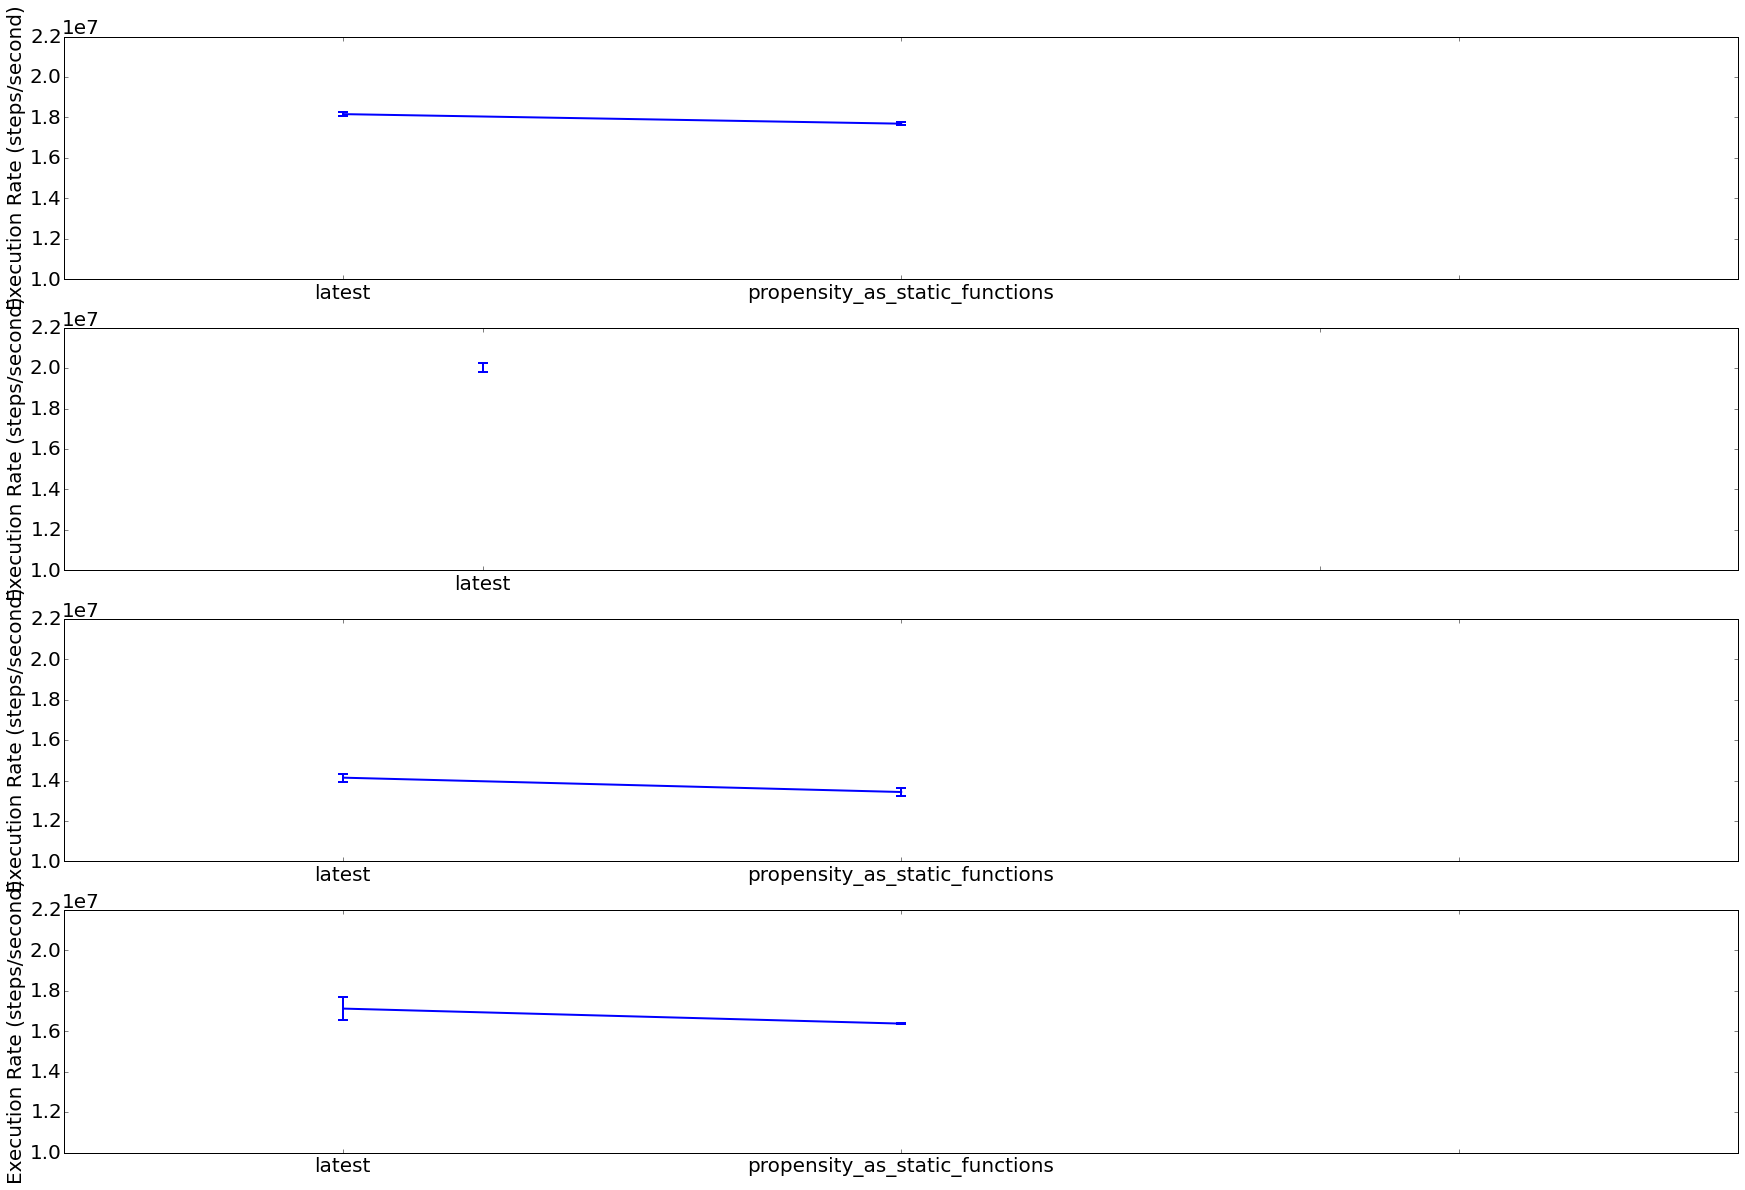

In [7]:
# Plot the previous timing data.
matplotlib.rcParams.update({'font.size': 20, "figure.figsize": (30,20)})
hosts = timingData.keys()
hosts.sort()
for i,host in enumerate(hosts):
    testTypes=timingData[host].keys()
    testTypes.sort()
    times=[]
    timesErr=[]
    for testType in testTypes:
        times.append(mean(timingData[host][testType]))
        timesErr.append(std(timingData[host][testType]))
    plt.subplot(len(hosts),1,i+1)
    plt.errorbar(arange(0,len(testTypes))+0.5,times,linewidth=2,yerr=timesErr,elinewidth=2,capsize=5,capthick=2)
    plt.ylabel('Execution Rate (steps/second)')
    plt.xticks(arange(0,len(hosts))+0.5, testTypes)
    plt.xlim([0,len(testTypes)+1]); plt.ylim([1e7,2.2e7])
pass

billy rae